# ***Cart***

El argumento `class_weight="balanced"` en clasificadores de Scikit-learn ajusta automáticamente los pesos asignados a cada clase inversamente proporcional a su frecuencia en los datos de entrenamiento. Matemáticamente, el peso asignado a la clase  $c$ se define como:

$$
w_c = \frac{n}{k \cdot n_c}
$$

donde  $n$ es el número total de muestras,  $k$ es el número total de clases y  $n_c$ es el número de muestras pertenecientes a la clase  $c$. Este ajuste tiene como objetivo equilibrar la contribución de cada clase a la función de pérdida durante el entrenamiento, penalizando más los errores cometidos sobre clases minoritarias y reduciendo el sesgo hacia las clases mayoritarias. El uso de este ajuste es particularmente útil en problemas de clasificación desbalanceada cuando no se desea modificar la distribución original mediante técnicas de sobremuestreo o submuestreo. El efecto práctico es que la función de pérdida se pondera según la importancia relativa de cada clase, mejorando la sensibilidad en clases con baja representación sin necesidad de alterar los datos.

In [1]:
import os
import random
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, label_binarize, OrdinalEncoder
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)
import lime.lime_tabular
import time
from sklearn.preprocessing import LabelEncoder

from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

/Users/sergiosilveramurcia/Conda/miniconda3/envs/MachineLearning/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# =======================
# LOAD DATA
# =======================
file_path = "../Datos_Saber_Pro_Preprocesed.csv"
df = pd.read_csv(file_path)
X = df.drop(columns=["MOD_INGLES_DESEM"])
y = df["MOD_INGLES_DESEM"]


In [3]:
le = LabelEncoder()
y = pd.Series(le.fit_transform(y), index=y.index)

class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class mapping:", class_mapping)

Class mapping: {'-A1': np.int64(0), 'A1': np.int64(1), 'A2': np.int64(2), 'B1': np.int64(3), 'B2': np.int64(4)}


In [6]:
# =======================
# FILE PATHS
# =======================
model_filename = "../Models/best_decision_tree_model_.pkl"
study_filename = "../Study/optuna_study_DT_nested_.pkl"
metrics_filename = "../Models/best_decision_tree_metrics_.pkl"
fold_metrics_filename = "./Metrics/cart_folds_summary_.csv"

In [ ]:
# =======================
# PIPELINE BUILDER
# =======================

# Explicitly ordered categorical columns
ORDINAL_COLUMNS = {
    'FAMI_ESTRATOVIVIENDA': None,  # implicit order (numeric codes)
    'FAMI_EDUCACIONPADRE': None,  
    'FAMI_EDUCACIONMADRE': None,
    'ESTU_HORASSEMANATRABAJA': [
        '0',
        'Menos de 10 horas',
        'Entre 11 y 20 horas',
        'Entre 21 y 30 horas',
        'Más de 30 horas'
    ],
    'ESTU_VALORMATRICULAUNIVERSIDAD': [
        "No pagó matrícula",
        "Menos de 500 mil",
        "Entre 500 mil y menos de 1 millón",
        "Entre 1 millón y menos de 2.5 millones",
        "Entre 2.5 millones y menos de 4 millones",
        "Entre 4 millones y menos de 5.5 millones",
        "Entre 5.5 millones y menos de 7 millones",
        "Más de 7 millones"
    ]
}


def build_pipeline(params: dict, X: pd.DataFrame = None) -> Pipeline:
    if X is None:
        raise ValueError("X must be provided to build the pipeline dynamically.")

    categorical_features = X.select_dtypes(include='object').columns.tolist()
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    ordinal_cols = [col for col in ORDINAL_COLUMNS if col in X.columns]
    nominal_cols = [col for col in categorical_features if col not in ordinal_cols]

    transformers = [
        ('num', SimpleImputer(strategy='median'), numeric_features)
    ]

    if nominal_cols:
        transformers.append(('ohe_cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))
        ]), nominal_cols))

    if ordinal_cols:
        for col in ordinal_cols:
            categories = [ORDINAL_COLUMNS[col]] if ORDINAL_COLUMNS[col] is not None else 'auto'
            transformers.append((f'ord_{col}', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
                ('ord', OrdinalEncoder(categories=categories if categories != 'auto' else 'auto',
                                       handle_unknown='use_encoded_value', unknown_value=-1))
            ]), [col]))

    preprocessor = ColumnTransformer(
        transformers,
        remainder='drop',
        verbose_feature_names_out=False
    )
    
    model = DecisionTreeClassifier(**params, random_state=SEED, class_weight="balanced")
    return Pipeline([('preprocessor', preprocessor), ('classifier', model)])


In [8]:
# =======================
# MODEL EVALUATION
# =======================
def evaluate_model(model: Pipeline, X_data: pd.DataFrame, y_data: pd.Series) -> tuple:
    """
    Returns evaluation metrics for a trained model on given data.
    """
    y_pred = model.predict(X_data)
    y_proba = model.predict_proba(X_data)
    f1 = f1_score(y_data, y_pred, average='weighted')
    acc = accuracy_score(y_data, y_pred)
    loss = log_loss(y_data, y_proba)
    auc = roc_auc_score(y_data, y_proba, multi_class='ovr', average='weighted')
    report = classification_report(y_data, y_pred)
    cm = confusion_matrix(y_data, y_pred)
    return f1, acc, loss, auc, report, cm, y_proba, y_pred

In [9]:

# =======================
# HYPERPARAMETER TUNING
# =======================
def run_inner_optuna(X_inner: pd.DataFrame, y_inner: pd.Series, n_trials: int = 100) -> tuple:
    """
    Inner CV loop using Optuna to optimize DecisionTree hyperparameters.
    """
    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 30),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "ccp_alpha": trial.suggest_float("ccp_alpha", 1e-5, 1e-2, log=True),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 30, 100)
        }
        pipeline = build_pipeline(params, X_inner)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        scores = []
        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            pipeline.fit(X_t, y_t)
            y_pred = pipeline.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))
        return np.mean(scores)

    pruner = MedianPruner()
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=n_trials)
    return study.best_params, study

In [10]:
# =======================
# FOLD METRIC SAVER
# =======================
def save_metrics_folds(folds_metrics: list, filename: str) -> pd.DataFrame:
    """
    Saves per-fold metrics + final rows for mean and std in a single CSV.
    Returns full DataFrame (raw + summary).
    """
    df = pd.DataFrame(folds_metrics)

    metric_cols = df.columns.drop('fold') if 'fold' in df.columns else df.columns
    mean_row = df[metric_cols].mean().to_dict()
    std_row = df[metric_cols].std().to_dict()

    mean_row['fold'] = 'mean'
    std_row['fold'] = 'std'

    df_final = pd.concat([df, pd.DataFrame([mean_row, std_row])], ignore_index=True)

    df_final.to_csv(filename, index=False)
    print(f"📁 Fold metrics + summary saved to: {filename}")
    return df_final

# =======================
# PLOT CONFUSION MATRIX
# =======================
def plot_confusion_matrix(cm, labels, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

In [11]:
# =======================
# LIME EXPLAINER BUILDER
# =======================
def get_lime_explainer(model_pipeline: Pipeline, X_train_raw: pd.DataFrame, y_train_raw: pd.Series):
    """
    Constructs LIME explainer using preprocessed training data.
    """
    X_transformed = model_pipeline.named_steps['preprocessor'].transform(X_train_raw)
    feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
    class_names = np.unique(y_train_raw).astype(str)
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_transformed,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    return explainer, X_transformed

In [12]:
def nested_cv(X: pd.DataFrame, y: pd.Series) -> tuple:
    """
    Executes nested CV with full metric tracking (train/val/test), including classification reports,
    confusion matrices and predict_proba for LIME. Also includes Optuna visualizations.
    """
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    optuna_studies = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_f1 = -np.inf
    best_model = None
    best_metrics = {}

    for fold, (train_idx, test_idx) in tqdm(
        enumerate(outer_cv.split(X, y), 1),
        total=outer_cv.get_n_splits(),
        desc="Training folds"
    ):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        # Extra validation split for reporting
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_fold, y_train_fold,
            test_size=0.2,
            stratify=y_train_fold,
            random_state=SEED
        )

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr)
        optuna_time = time.time() - start_time
        optuna_studies.append(study)
        model = build_pipeline(best_params, X_tr)
        model.fit(X_tr, y_tr)

        # FULL train evaluation
        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = evaluate_model(model, X_tr, y_tr)

        # Validation evaluation
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = evaluate_model(model, X_val, y_val)

        # Outer test evaluation
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": optuna_time
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": model.named_steps['classifier'].classes_,
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump({'studies': optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    df_folds = save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    # Visualizations for best study
    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)
    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations

In [13]:
# Run pipeline
model, metrics, study, visualizations = nested_cv(X, y)

In [14]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  []),
                                                 ('ohe_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Sin '
                                                                                            'Dato',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['FAMI_TIENEAUTOMOVIL',
                                                   'FAMI_TIENECOMPUTADOR',
                                                   'FAMI_TIENEINTERNET',
                                                   'FAMI_TIENELAVADORA',
                                                   'ESTU_NU...
                                                                                               'de '
                                                                                               '7 '
                                                                                               'millones',
                                                                                               'Más '
                                                                                               'de '
                                                                                               '7 '
                                                                                               'millones']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['ESTU_VALORMATRICULAUNIVERSIDAD'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=1.761513962208274e-05,
                                        class_weight='balanced', max_depth=8,
                                        max_leaf_nodes=47, min_samples_leaf=3,
                                        min_samples_split=19,
                                        random_state=42))])

In [15]:
metrics.keys()

dict_keys(['fold', 'f1_train', 'accuracy_train', 'log_loss_train', 'auc_train', 'f1_val', 'accuracy_val', 'log_loss_val', 'auc_val', 'f1_test', 'accuracy_test', 'log_loss_test', 'auc_test', 'optuna_time', 'params', 'labels', 'best_fold', 'X_train_fold', 'y_train_fold', 'y_train_pred', 'y_train_true', 'y_proba_train', 'classification_report_train', 'confusion_matrix_train', 'y_val_true', 'y_val_pred', 'y_proba_val', 'classification_report_val', 'confusion_matrix_val', 'y_test_fold', 'y_test_pred', 'y_proba_test', 'classification_report_test', 'confusion_matrix_test'])

In [16]:
print(metrics['classification_report_train'])

              precision    recall  f1-score   support

           0       0.20      0.50      0.29     19646
           1       0.29      0.16      0.21     44604
           2       0.50      0.37      0.42     80890
           3       0.32      0.31      0.32     46259
           4       0.37      0.61      0.46     21226

    accuracy                           0.35    212625
   macro avg       0.34      0.39      0.34    212625
weighted avg       0.38      0.35      0.35    212625



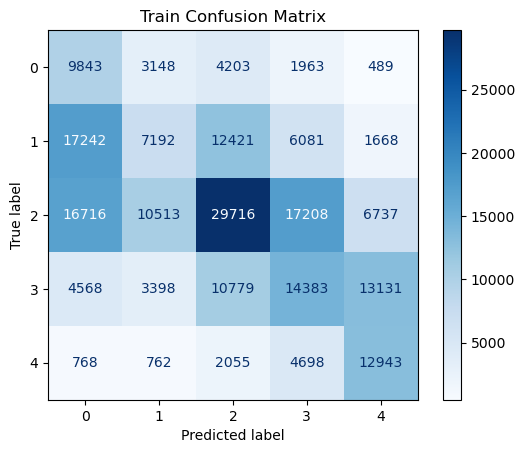

In [17]:
plot_confusion_matrix(metrics['confusion_matrix_train'], metrics['labels'], "Train Confusion Matrix")

In [18]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.20      0.51      0.29      4912
           1       0.29      0.17      0.21     11151
           2       0.50      0.36      0.42     20223
           3       0.32      0.31      0.32     11565
           4       0.37      0.61      0.46      5306

    accuracy                           0.35     53157
   macro avg       0.34      0.39      0.34     53157
weighted avg       0.38      0.35      0.35     53157



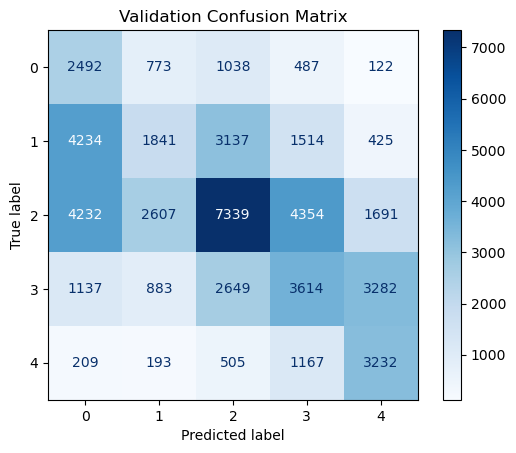

In [19]:
plot_confusion_matrix(metrics['confusion_matrix_val'], metrics['labels'], "Validation Confusion Matrix")

In [20]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.21      0.52      0.30      6140
           1       0.29      0.16      0.21     13938
           2       0.50      0.37      0.43     25279
           3       0.33      0.31      0.32     14456
           4       0.36      0.59      0.45      6633

    accuracy                           0.35     66446
   macro avg       0.34      0.39      0.34     66446
weighted avg       0.38      0.35      0.35     66446



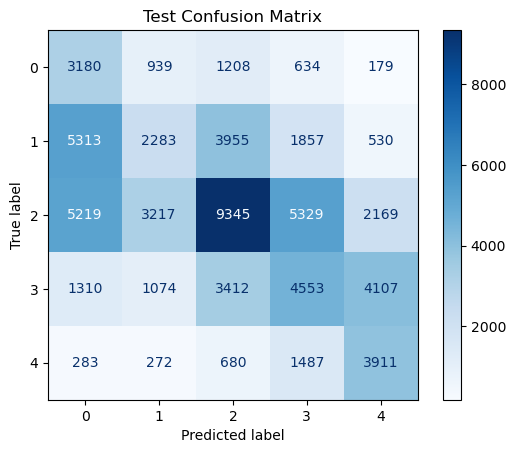

In [21]:
plot_confusion_matrix(metrics['confusion_matrix_test'], metrics['labels'], "Test Confusion Matrix")

In [22]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  []),
                                                 ('ohe_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Sin '
                                                                                            'Dato',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['FAMI_TIENEAUTOMOVIL',
                                                   'FAMI_TIENECOMPUTADOR',
                                                   'FAMI_TIENEINTERNET',
                                                   'FAMI_TIENELAVADORA',
                                                   'ESTU_NU...
                                                                                               'de '
                                                                                               '7 '
                                                                                               'millones',
                                                                                               'Más '
                                                                                               'de '
                                                                                               '7 '
                                                                                               'millones']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['ESTU_VALORMATRICULAUNIVERSIDAD'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=1.761513962208274e-05,
                                        class_weight='balanced', max_depth=8,
                                        max_leaf_nodes=47, min_samples_leaf=3,
                                        min_samples_split=19,
                                        random_state=42))])

In [30]:
# Feature Importance Plot
importances = model.named_steps['classifier'].feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

fig = px.bar(importance_df,
             x='Feature',
             y='Importance',
             title='Top 20 Feature Importance of the Decision Tree Model',
             labels={'Feature': 'Feature Name', 'Importance': 'Importance Score'},
             color='Importance',
             color_continuous_scale='Viridis',
             text='Importance')
fig.update_layout(xaxis_tickangle=45)
fig.show()

In [31]:
reporte.save(metrics, model_name="CART")


✅ Report for model 'CART' saved:
   → CSV: ./Metrics/Metrics_CART.csv
   → JSON: ./Metrics/Metrics_CART.json


In [38]:
def plot_roc_multiclass(y_true, y_proba, class_labels, title="AUC-ROC Curve (Multiclass)"):
    # Binarize true labels
    y_bin = label_binarize(y_true, classes=class_labels)
    n_classes = len(class_labels)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f"Class {class_labels[i]} (AUC = {roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


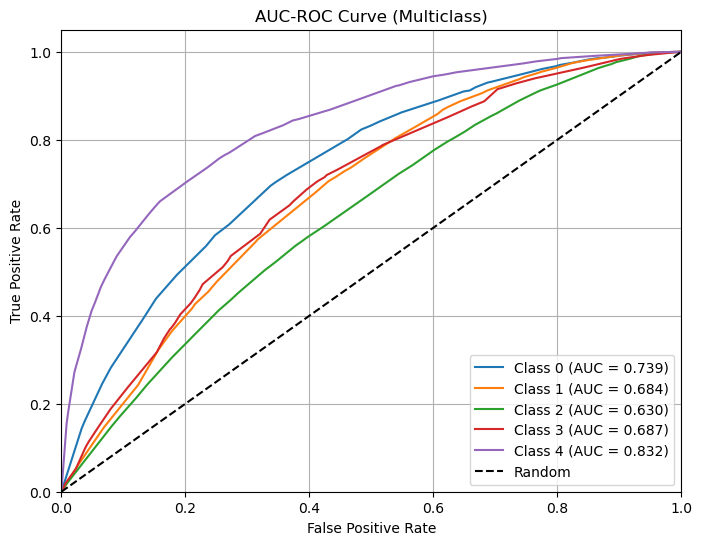

In [39]:
plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
    class_labels=metrics["labels"]
)

In [40]:
model.named_steps["classifier"].get_params()

{'ccp_alpha': 1.761513962208274e-05,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': 47,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 19,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [51]:
df = pd.read_csv(fold_metrics_filename)
df

,fold,f1_train,accuracy_train,log_loss_train,auc_train,f1_val,accuracy_val,log_loss_val,auc_val,f1_test,accuracy_test,log_loss_test,auc_test,optuna_time
0,1,0.347,0.348,1.410,0.689,0.348,0.349,1.413,0.687,0.343,0.343,1.412,0.686,694.023
1,2,0.346,0.348,1.414,0.686,0.346,0.348,1.416,0.684,0.348,0.350,1.419,0.684,1591.777
2,3,0.346,0.346,1.407,0.689,0.346,0.347,1.412,0.686,0.347,0.347,1.409,0.689,2217.078
3,4,0.342,0.344,1.400,0.692,0.341,0.343,1.404,0.692,0.339,0.341,1.404,0.691,2314.593
4,5,0.324,0.329,1.407,0.689,0.325,0.330,1.409,0.690,0.322,0.328,1.411,0.689,1581.424
5,mean,0.341,0.343,1.408,0.689,0.341,0.343,1.411,0.688,0.340,0.342,1.411,0.688,1679.779
6,std,0.010,0.008,0.005,0.002,0.009,0.008,0.005,0.003,0.010,0.009,0.006,0.003,648.231
